# Chapter 1 - Understanding Deep Learning Anomaly Detection

[PyOD](https://github.com/yzhao062/pyod), is an open-source Python library that provides over 40 outlier detection algorithms, covering from outlier ensembles to neural network-based methods on multivariate data under a unified API. This notebook covers a **fraud detection** example using AutoEncoder provided by PyOD and an [anonymized credit card transactions dataset available at Kaggle](https://www.kaggle.com/datasets/whenamancodes/fraud-detection). 

You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free ML development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Setup

Install and load essential libraries.

In [2]:
# Install required libraries

import sys
!{sys.executable} -m pip install -r requirements.txt

In [3]:
# Load the essential libraries

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from platform import python_version
import tensorflow as tf
from pyod.models.auto_encoder import AutoEncoder

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.11.0
Python version: 3.9.10


## Prepare Data

Load and prepare the dataset.

In [4]:
# Load and preview the dataset

df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Assign model features and the target label column to variables

model_features = df.columns.drop('Class')
X = df[model_features]
y = df['Class']

In [6]:
# View the target label distribution

y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# View the number of rows and columns of model features

X.shape

(284807, 30)

## Train a Model

In [8]:
# Set the contamination and epochs. Contamination ranges between 0 and 0.5 with 0.1 as default value.

contamination = 0.5 
epochs = 30

In [9]:
# Set the number of neurons per hidden layers

hn = [64, 30, 30, 64]

# Instantiate AutoEncoder and start training

clf = AutoEncoder(epochs=epochs, contamination=contamination, hidden_neurons=hn)
clf.fit(X)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                1984      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                1

AutoEncoder(batch_size=32, contamination=0.5, dropout_rate=0.2, epochs=30,
      hidden_activation='relu', hidden_neurons=[64, 30, 30, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7ff37745d5e0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

## Identify Outliers

In [10]:
# Obtain prediction on outliers

outliers = clf.predict(X)

8901/8901 [==============================] - 10s 1ms/step


In [11]:
# Filter outliers

anomaly = np.where(outliers==1)
anomaly

(array([     2,      3,      7, ..., 284803, 284804, 284805]),)

In [12]:
# Predict a test instance

sample = X.iloc[[4920]]

clf.predict(sample, return_confidence=False)

1/1 [==============================] - 0s 22ms/step


array([1])

In [13]:
X.iloc[[4920]]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
4920,4462.0,-2.30335,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.56232,-0.399147,-0.238253,...,-0.430022,-0.294166,-0.932391,0.172726,-0.08733,-0.156114,-0.542628,0.039566,-0.153029,239.93


In [14]:
y.iloc[[4920]]

4920    1
Name: Class, dtype: int64

In [15]:
# Ground truth fraudulent transactions

df.loc[df['Class'] == 1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [16]:
# Show model's confidence if trained using perturbed data

clf.predict_confidence(sample)

1/1 [==============================] - 0s 21ms/step


array([1.])

In [17]:
# Generate binary labels of the training data. 0 means inliers and 1 means outliers

y_pred = clf.labels_  

# Calculate outlier scores of the training data. Higher scores means higher severity of abnormalities

y_scores = clf.decision_scores_ 

In [18]:
y_pred[:5]

array([0, 0, 1, 1, 0])

In [19]:
y_scores[:5]

array([3.76583221, 3.29441926, 6.76313105, 5.02222389, 4.02433063])

## Evaluate Model

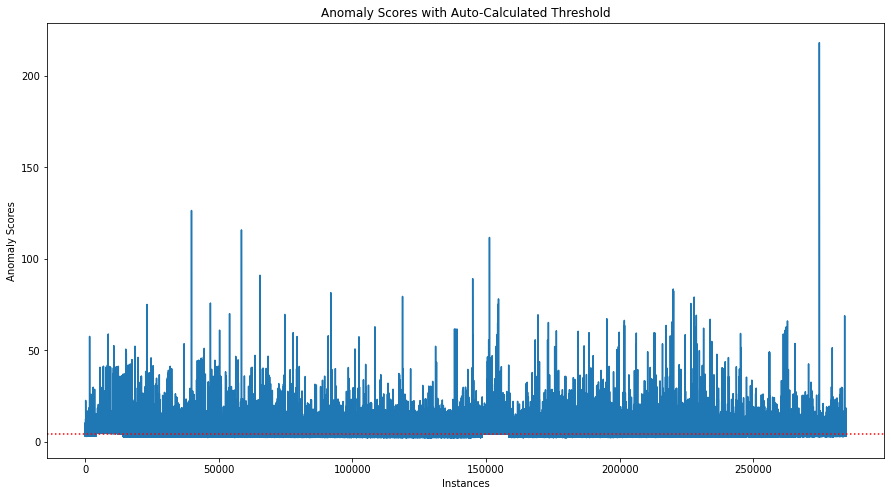

In [20]:
# Visualize auto-calculated anomaly scores. Red horizontal line represents threshold.

plt.rcParams["figure.figsize"] = (15,8)
plt.plot(y_scores);
plt.axhline(y=clf.threshold_, c='r', ls='dotted', label='threshold');
plt.xlabel('Instances')
plt.ylabel('Anomaly Scores')
plt.title('Anomaly Scores with Auto-Calculated Threshold');
plt.show()

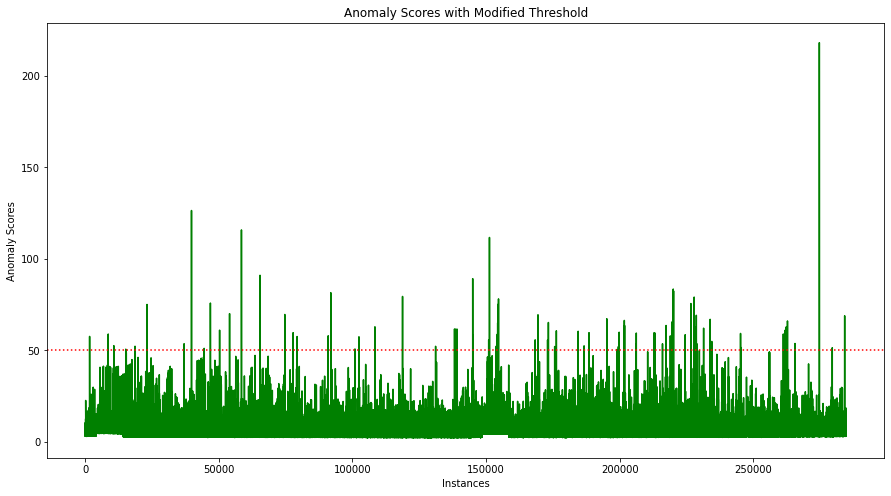

In [21]:
# Modify the threshold and view the new distribution. Red horizontal line represents the manually changed threshold.

threshold = 50
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(y_scores, color="green");
plt.axhline(y=threshold, c='r', ls='dotted', label='threshold');
plt.xlabel('Instances')
plt.ylabel('Anomaly Scores')
plt.title('Anomaly Scores with Modified Threshold');
plt.show()

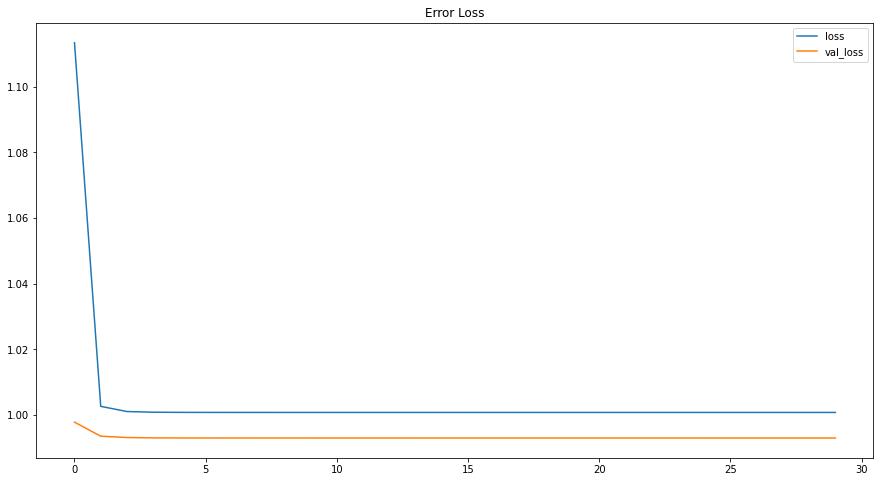

In [22]:
# View loss history
plt.rcParams["figure.figsize"] = (15,8)
pd.DataFrame.from_dict(clf.history_).plot(title='Error Loss');
plt.show()

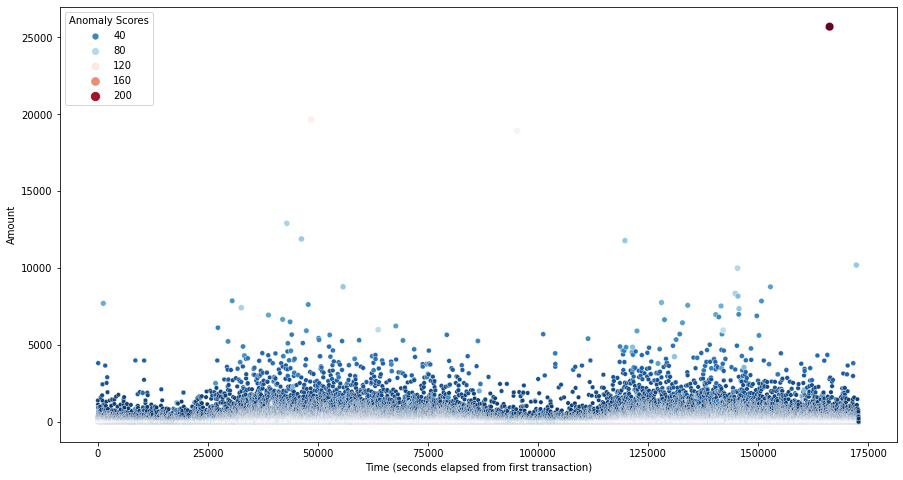

In [23]:
# Visualize a scatter plot

sns.scatterplot(x="Time", y="Amount", hue=y_scores, data=df, palette="RdBu_r", size=y_scores);
plt.xlabel('Time (seconds elapsed from first transaction)')
plt.ylabel('Amount')
plt.legend(title='Anomaly Scores')
plt.show()

This concludes a walkthrough of fraud detection using AutoEncoder by PyOD. You can explore other [outlier detection models provided by PyOD](https://pyod.readthedocs.io/en/latest/pyod.models.html#). 